In [1]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [2]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

###### for now reduce in size to save time

In [4]:
### sample and reduce poth splits to 10% of the original size


print(f"Original train_data length: {len(train_data)}")
print(f"Original test_data length: {len(test_data)}")


train_data = train_data.select(indices=np.random.choice(len(train_data), len(train_data)//10))
test_data = test_data.select(indices=np.random.choice(len(test_data), len(test_data)//10))

print(f"Reduced train_data length: {len(train_data)}")
print(f"Reduced test_data length: {len(test_data)}")

Original train_data length: 25000
Original test_data length: 25000
Reduced train_data length: 2500
Reduced test_data length: 2500


In [5]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [6]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [7]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

In [8]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [9]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [10]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [11]:
vocab.set_default_index(unk_index)

In [12]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [13]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

In [14]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [15]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [16]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [17]:
batch_size = 320

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [19]:
print("number of training samples: ", len(train_data))
print(1875-(batch_size * 5))

number of training samples:  1875
275


In [20]:
print(f"Number of train batches: {len(train_data_loader)}")
print(f"Number of valid batches: {len(valid_data_loader)}")
print(f"Number of test batches: {len(test_data_loader)}")

Number of train batches: 6
Number of valid batches: 2
Number of test batches: 8


In [21]:
def register_save_activations_hook(model, model_activation_layer, activations_list):
    """Registers a forward pass hook that saves activations.
    
    Args:
        model(nn.Module): A PyTorch model.
        model_activation_layer(str): The name of the module in the network that
            produces the activations of interest.
        activations_list(List[torch.Tensor]) The list in which we should store the
            model activations.
    """
    def save_activations(model, inp, out):
        print(f"save_activations: {out.size()}")       
        activations_list.append(out.view(out.size(0), -1))

    for name, m in model.named_modules():
        if name == model_activation_layer or \
          (isinstance(model, torch.nn.DataParallel) and \
           name.replace('module.', '') == model_activation_layer):
            return m.register_forward_hook(save_activations)
    return None

In [22]:
class CNN(nn.Module):



    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(embedding_dim, n_filters, filter_size)
                for filter_size in filter_sizes
            ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

        ## last layer name
        self.activation_layer_name =f"convs.{len(filter_sizes)-1}"

    def _init_activations_hook(self, model, activations_list):
        """Initializes the forward hook to save model activations."""
        if isinstance(model, torch.nn.DataParallel):
            activation_layer = model.module.activation_layer_name
        else:
            activation_layer = model.activation_layer_name
        activations_handle = register_save_activations_hook(model, activation_layer,
                                                            activations_list)
        if activation_layer is not None:
            assert activations_handle is not None, \
                f'No hook registered for activation_layer={activation_layer}'
        return activations_handle


    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        embedded = embedded.permute(0, 2, 1)
        # embedded = [batch size, embedding dim, seq len]
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]
        pooled = [conv.max(dim=-1).values for conv in conved]
        # pooled_n = [batch size, n filters]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        # cat = [batch size, n filters * len(filter_sizes)]
        prediction = self.fc(cat)
        # prediction = [batch size, output dim]
        return prediction

In [23]:
def get_model():    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    x = Reshape((m, n, 300))(x)
    #print(x)
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 2), 
                                                                                    activation='relu')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 3),
                                                                                    activation='relu')(x)
    
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 4),
                                                                                    activation='relu')(x)
    
    
    
    
    
    conv_4 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 1), 
                                                                                    activation='relu')(x)
    conv_5 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 2), activation='relu')(x)
    
    conv_6 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 3),
                                                                                    activation='relu')(x)
    
    
    
    maxpool_0 = MaxPool2D()(conv_0)
    maxpool_0=Flatten()(maxpool_0)
    maxpool_1 = MaxPool2D()(conv_1)
    maxpool_1=Flatten()(maxpool_1)
    maxpool_2 = MaxPool2D()(conv_2)
    maxpool_2 = Flatten()(maxpool_2)
    
    maxpool_4 = MaxPool2D()(conv_4)
    maxpool_4=Flatten()(maxpool_4)
    maxpool_5 = MaxPool2D()(conv_5)
    maxpool_5=Flatten()(maxpool_5)
    maxpool_6 = MaxPool2D()(conv_6)
    maxpool_6=Flatten()(maxpool_6)
    #maxpool_7 = MaxPool2D()(conv_7)
   # maxpool_7=Flatten()(maxpool_7)
    z = concatenate([maxpool_0, maxpool_1,maxpool_2],axis=1)
    w=concatenate([maxpool_4, maxpool_5,maxpool_6],axis=1)    
    #w=concatenate([maxpool_4, maxpool_5,maxpool_6],axis=1)    
    #z = concatenate([maxpool_0, maxpool_1,maxpool_2,maxpool_4, maxpool_5,maxpool_6],axis=1)
    #z = concatenate([maxpool_0, maxpool_1,maxpool_4, maxpool_5],axis=1)
    
    #z = Flatten()(z)
    z=concatenate([w,z],axis=1)
    z=Dense(units=64,activation="relu")(z)
    z = Dropout(0.4)(z)
        
    outp = Dense(1, activation="sigmoid")(z)
    
    model = Model(inputs=inp, outputs=outp)
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [24]:



class CNN_paper (nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()





        ## not even sure what the reason behind the values are
        self.m = 10
        self.n = 5
        self.penultimate_dim = 64

        self.num_filters = n_filters
        self.filter_sizes = [4,6]






        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.layer_spatial_dropout = nn.Dropout1d(0.4)
        self.convs = nn.ModuleList(
            [
                nn.Conv2d(embedding_dim,self.num_filters, kernel_size=(self.filter_sizes[0], 2)),
                nn.Conv2d(embedding_dim,self.num_filters, kernel_size=(self.filter_sizes[0], 3)),
                nn.Conv2d(embedding_dim,self.num_filters, kernel_size=(self.filter_sizes[0], 4)),
                nn.Conv2d(embedding_dim,self.num_filters, kernel_size=(self.filter_sizes[1], 1)),
                nn.Conv2d(embedding_dim,self.num_filters, kernel_size=(self.filter_sizes[1], 2)),
                nn.Conv2d(embedding_dim,self.num_filters, kernel_size=(self.filter_sizes[1], 3))
                
            ]
        )
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2))
        self.flatten = nn.Flatten()

        
        self.penultimate_layer = nn.Linear( 3 * self.num_filters, self.penultimate_dim )
        
        self.fc = nn.Linear(self.penultimate_dim , output_dim)
        self.dropout = nn.Dropout(dropout_rate)

        
        self.activation_layer_name =f"penultimate_layer"


    def _init_activations_hook(self, model, activations_list):
        """Initializes the forward hook to save model activations."""
        if isinstance(model, torch.nn.DataParallel):
            activation_layer = model.module.activation_layer_name
        else:
            activation_layer = model.activation_layer_name
        activations_handle = register_save_activations_hook(model, activation_layer,
                                                            activations_list)
        if activation_layer is not None:
            assert activations_handle is not None, \
                f'No hook registered for activation_layer={activation_layer}'
        return activations_handle


    def forward(self, ids):
        # # ids = [batch size, seq len]
        # embedded = self.dropout(self.embedding(ids))
        # # embedded = [batch size, seq len, embedding dim]
        # embedded = embedded.permute(0, 2, 1)
        # # embedded = [batch size, embedding dim, seq len]
        # conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]
        # pooled = [conv.max(dim=-1).values for conv in conved]
        # # pooled_n = [batch size, n filters]
        # cat = self.dropout(torch.cat(pooled, dim=-1))
        # # cat = [batch size, n filters * len(filter_sizes)]
        # prediction = self.fc(cat)
        # # prediction = [batch size, output dim]
        # return prediction


        embedded = self.embedding(ids)
        embedded = self.layer_spatial_dropout(embedded)
        # print(embedded.size())
        # embedded = torch.reshape(embedded, (self.m, self.n,300))

        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        
        ## this could be dne better..
        pooled = [self.maxpool(conv) for conv in conved]
        flattened = [self.flatten(pool) for pool in pooled]
        
        ## why not concatenate in one step????
        z = torch.cat(flattened[0,3], dim=-1)
        w = torch.cat(flattened[4,6], dim=-1)

        ## TODO look up the reasoning for this, this is strange..
        z = torch.cat(z,w, dim=-1)
        penultimate = torch.relu(self.penultimate_layer(z))
        penultimate = self.dropout(penultimate)
        prediction = self.fc(penultimate)

        return prediction


In [25]:
vocab_size = len(vocab)
embedding_dim = 300
n_filters = 100
filter_sizes = [3, 5, 7]
output_dim = len(train_data.unique("label"))
dropout_rate = 0.25

model = CNN(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    output_dim,
    dropout_rate,
    pad_index,
)

In [26]:
vocab_size = len(vocab)
embedding_dim = 300
n_filters = 100
# filter_sizes = [3, 5, 7]
filter_sizes = [4,6]
output_dim = len(train_data.unique("label"))
dropout_rate = 0.25

model = CNN_paper(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    output_dim,
    dropout_rate,
    pad_index,
)

In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 3,739,094 trainable parameters


In [27]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

In [28]:
model.apply(initialize_weights)

CNN_paper(
  (embedding): Embedding(5197, 300, padding_idx=1)
  (layer_spatial_dropout): Dropout1d(p=0.4, inplace=False)
  (convs): ModuleList(
    (0): Conv2d(300, 100, kernel_size=(4, 2), stride=(1, 1))
    (1): Conv2d(300, 100, kernel_size=(4, 3), stride=(1, 1))
    (2): Conv2d(300, 100, kernel_size=(4, 4), stride=(1, 1))
    (3): Conv2d(300, 100, kernel_size=(6, 1), stride=(1, 1))
    (4): Conv2d(300, 100, kernel_size=(6, 2), stride=(1, 1))
    (5): Conv2d(300, 100, kernel_size=(6, 3), stride=(1, 1))
  )
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (penultimate_layer): Linear(in_features=300, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [29]:
vectors = torchtext.vocab.GloVe()

In [30]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [31]:
print(pretrained_embedding.shape)

torch.Size([5197, 300])


In [32]:
model.embedding.weight.data = pretrained_embedding

In [33]:
optimizer = optim.Adam(model.parameters())

In [34]:
criterion = nn.CrossEntropyLoss()

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [36]:
model = model.to(device)
criterion = criterion.to(device)

###
N, C, W, H

In [39]:

data_loader = train_data_loader


sel_batch = next(iter(data_loader))

print(sel_batch["ids"].size())
ids = sel_batch["ids"].to(device)

ids = ids.cpu()
vocab_size = len(vocab)
print(vocab_size)
embedding_dim = 300

print(pad_index)


embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)

print(embedding.weight.size())
emdd = embedding(ids)
print(emdd.size())
emdd = emdd.permute(0, 2, 1)
print(emdd.size())

conv = nn.Conv2d(embedding_dim,100, kernel_size=(4, 2))
conv1d = nn.Conv1d(embedding_dim,100, kernel_size=4)

print(conv.weight.size())
print(conv1d.weight.size())


# cd1d = conv1d(emdd)
cd = conv(emdd)


torch.Size([320, 256])
5197
1
torch.Size([5197, 300])
torch.Size([320, 256, 300])
torch.Size([320, 300, 256])
torch.Size([100, 300, 4, 2])
torch.Size([100, 300, 4])


RuntimeError: Given groups=1, weight of size [100, 300, 4, 2], expected input[1, 320, 300, 256] to have 300 channels, but got 320 channels instead

In [68]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [56]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    epoch_activations = []

    activations_handle = model._init_activations_hook(model, epoch_activations)

    debug_counter = 0

    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        
        print(label.shape)
        print(epoch_activations[-1].shape)

        print("debug_counter: ", debug_counter)
        debug_counter += 1
    if activations_handle:
        print("removing handle")
        activations_handle.remove()

    return np.mean(epoch_losses), np.mean(epoch_accs), epoch_activations

In [38]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    epoch_activations = []

    activations_handle = model._init_activations_hook(model, epoch_activations)

    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    if activations_handle:
        activations_handle.remove()
    return np.mean(epoch_losses), np.mean(epoch_accs), epoch_activations

In [69]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

activations = {}

for epoch in range(n_epochs):
    train_loss, train_acc, train_activations = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc, val_activations = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

    ### save activations
    activations[epoch] = {"train": train_activations, "val": val_activations}

training...:   0%|          | 0/8 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [100, 300, 4, 2], expected input[1, 256, 256, 300] to have 300 channels, but got 256 channels instead

In [41]:
print(model)

CNN(
  (embedding): Embedding(5197, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


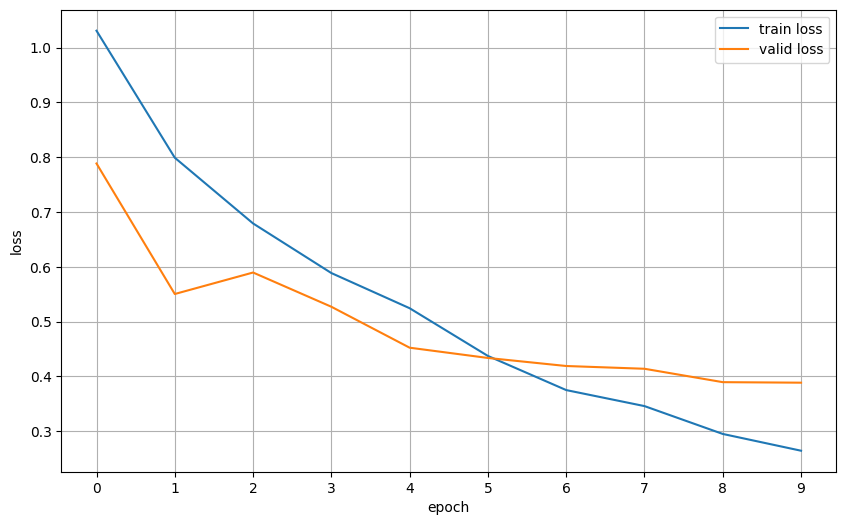

In [42]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

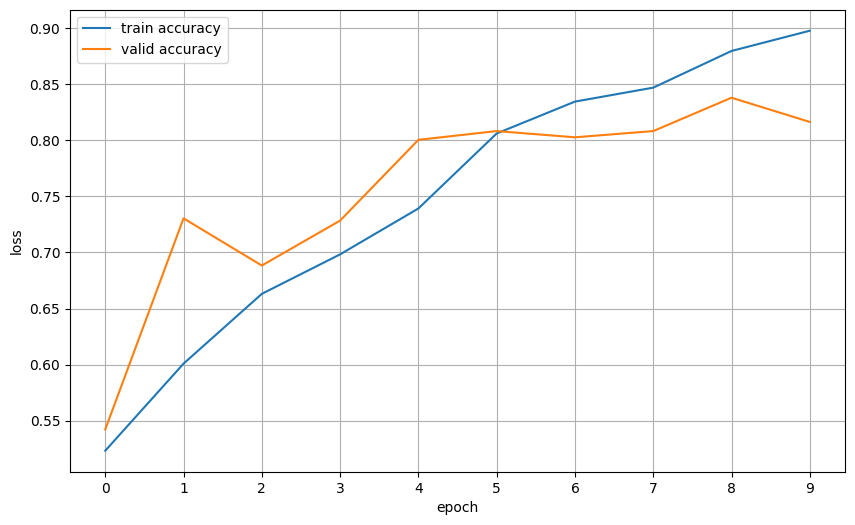

In [43]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [44]:
model.load_state_dict(torch.load("cnn.pt"))

test_loss, test_acc, val_activations = evaluate(test_data_loader, model, criterion, device)

evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

evaluating...: 100%|██████████| 10/10 [00:00<00:00, 49.28it/s]

save_activations: torch.Size([256, 100, 250])
save_activations: torch.Size([256, 100, 250])
save_activations: torch.Size([256, 100, 250])
save_activations: torch.Size([256, 100, 250])
save_activations: torch.Size([256, 100, 250])
save_activations: torch.Size([256, 100, 250])
save_activations: torch.Size([256, 100, 250])
save_activations: torch.Size([256, 100, 250])
save_activations: torch.Size([256, 100, 250])
save_activations: torch.Size([196, 100, 250])


In [45]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.405, test_acc: 0.814


In [46]:
def predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    if len(ids) < min_length:
        ids += [pad_index] * (min_length - len(ids))
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [47]:
text = "This film is terrible!"
min_length = max(filter_sizes)

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(0, 0.9425516724586487)

In [111]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.9870288372039795)

In [112]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(0, 0.9049890041351318)

In [113]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.8051910400390625)

In [48]:
torch.save(activations, "activations.pt")

In [115]:
activations = torch.load("activations.pt")
print(activations.keys())
forth_epoch = activations[3]
print(forth_epoch.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys(['train', 'val'])


In [119]:
print(type(forth_epoch["train"]))
print(len(forth_epoch["train"]))

<class 'list'>
4


In [128]:
print(forth_epoch["train"][0].size())

torch.Size([512, 25000])


In [133]:
xxx = forth_epoch["train"][0]

In [135]:
print(xxx.size())

yyy = xxx.view(xxx.size(0), -1)
print(yyy.size())

torch.Size([512, 25000])
torch.Size([512, 25000])
